In [51]:
TRAIN_SET_PATH = "./vaccine_train_set.csv"
VALIDATION_SET_PATH = "./vaccine_validation_set.csv"

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import math

import matplotlib.pyplot as plt

In [53]:
trainDF = pd.read_csv(TRAIN_SET_PATH)
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [54]:
validDF = pd.read_csv(VALIDATION_SET_PATH)
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [55]:
features = trainDF.drop(['label', 'Unnamed: 0'], axis=1)
X_train = [ar[0] for ar in features.values]
trainLabels = trainDF['label'].values

features = validDF.drop(['label', 'Unnamed: 0'], axis=1)
X_valid = [ar[0] for ar in features.values]
validLabels = validDF['label'].values

In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def customPreprocessor(text: str):
    import re
    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

vectorizer = TfidfVectorizer(max_df=0.85, min_df=0.01)
# vectorizer = TfidfVectorizer(preprocessor=customPreprocessor, stop_words="english", max_df=0.85, min_df=0.01)
trainSamples = vectorizer.fit_transform(X_train)
validSamples = vectorizer.transform(X_valid)

In [57]:
from sklearn.metrics import f1_score, recall_score, precision_score
validPredictions = []
trainPredictions = []
trainSizes = [ math.floor(f*len(trainLabels)) for f in np.linspace(0.025, 1, 15) ]
lrClassifier = LogisticRegression(max_iter=math.inf)
for i in trainSizes:
    print('\r', i, end='')
    currentBatch = trainSamples[:i]
    lrClassifier.fit(currentBatch, trainLabels[:i])
    trainPredictions.append(lrClassifier.predict(currentBatch))
    validPredictions.append(lrClassifier.predict(validSamples))

 15976

In [58]:
trainF1Scores = {
    "F1": [],
    "Precision": [],
    "Recall": []
}
validF1Scores = {
    "F1": [],
    "Precision": [],
    "Recall": []
}
for tp, vp in zip(trainPredictions, validPredictions):
    x = len(tp)
    trainF1Scores["F1"].append(round(f1_score(trainLabels[:x], tp, average="micro"), 4))
    trainF1Scores["Precision"].append(round(precision_score(trainLabels[:x], tp, average="macro"), 4))
    trainF1Scores["Recall"].append(round(recall_score(trainLabels[:x], tp, average="macro"), 4))

    validF1Scores["F1"].append(round(f1_score(validLabels, vp, average="micro"), 4))
    validF1Scores["Precision"].append(round(precision_score(validLabels, vp, average="macro"), 4))
    validF1Scores["Recall"].append(round(recall_score(validLabels, vp, average="macro"), 4))

In [59]:
# _, axes = plt.subplots(1, 1, figsize=(8, 5))
# axes.grid()
# axes.set_title('F1 Scoring')
# axes.plot(trainSizes, trainF1Scores["f1"], "o-", color="r", label="Training Set score")
# axes.plot(trainSizes, validF1Scores["f1"], "o-", color="g", label="Validation Set score")
# axes.set_ylim((0.6, 0.75))
# axes.set_xlim((500, trainSizes[len(trainSizes) - 1]))
# axes.legend(loc="best")
# plt.show()

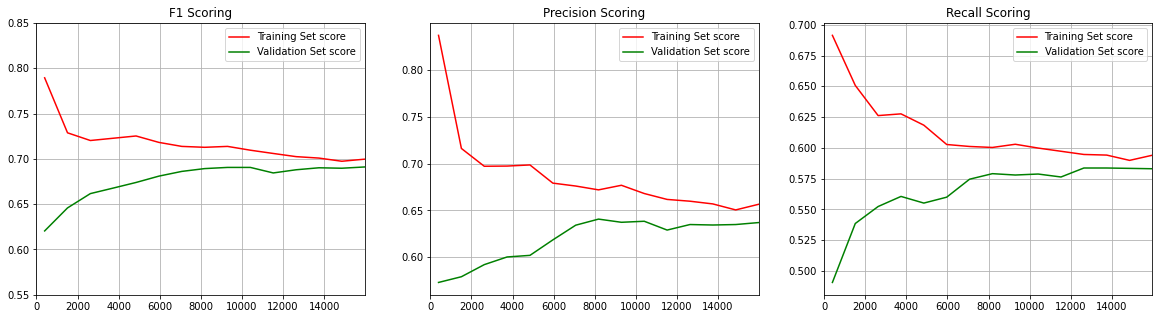

In [60]:
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].set_ylim((0.55, 0.85))
for i, metric in enumerate(trainF1Scores.keys()):
    axes[i].grid()
    axes[i].set_title(f'{metric} Scoring')
    axes[i].plot(trainSizes, trainF1Scores[metric], "-", color="r", label="Training Set score")
    axes[i].plot(trainSizes, validF1Scores[metric], "-", color="g", label="Validation Set score")    
    axes[i].set_xlim((0, trainSizes[len(trainSizes) - 1]))
    axes[i].legend(loc="best")
plt.show()